In [20]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load Data ---
with open("fine_mb_sweep.json", "r") as f:
    df = pd.DataFrame(json.load(f))
df.sort_values("run_id", inplace=True)
df

,run_id,bias_std_dev_scale,bias_height_fraction,perturbation_size,optimizer,found_minima,found_saddles,bias_count,energy_calls_at_each_min,force_calls_at_each_min
0,0,0.5,0.200000,0.005,FIRE,"[[0.6234994049, 0.02803775853], [-0.5574458886...","[[-0.8939429504162065, 0.5706991727804998]]",5000,"[1, 3178]","[1, 3178]"
1,1,0.5,0.200000,0.005,Scipy,"[[0.6234994049, 0.02803775853], [-0.5582236363...","[[0.10731579403014282, 0.040891827916547434]]",5000,"[1, 193]","[1, 193]"
1112,2,0.5,0.154853,0.005,FIRE,"[[0.6234994049, 0.02803775853], [-0.5571982545...","[[-0.90134879357643, 0.571191102442789]]",5000,"[1, 3732]","[1, 3732]"
1223,3,0.5,0.154853,0.005,Scipy,"[[0.6234994049, 0.02803775853], [-0.5576405053...","[[-0.7086634996338503, 0.528874696726882]]",5000,"[1, 465]","[1, 465]"
1334,4,0.5,0.119897,0.005,FIRE,"[[0.6234994049, 0.02803775853]]",[],5000,[1],[1]
...,...,...,...,...,...,...,...,...,...,...
1107,1995,0.1,0.033362,0.005,Scipy,"[[0.6234994049, 0.02803775853], [-0.0500108218...","[[-0.09444574531009187, 0.45048122120700906], ...",240,"[1, 2528, 5118]","[1, 2528, 5118]"
1108,1996,0.1,0.025831,0.005,FIRE,"[[0.6234994049, 0.02803775853], [-0.0500108607...","[[0.2385382753476558, 0.3305354903789308], [-0...",1487,"[1, 26593, 177561]","[1, 26593, 177561]"
1109,1997,0.1,0.025831,0.005,Scipy,"[[0.6234994049, 0.02803775853], [-0.5582236341...","[[0.22939651434620834, 0.25616846555966677], [...",989,"[1, 4768, 19713]","[1, 4768, 19713]"
1110,1998,0.1,0.020000,0.005,FIRE,"[[0.6234994049, 0.02803775853], [-0.0500107763...","[[0.2101424536524743, 0.29393639368901847], [-...",1897,"[1, 36467, 237619]","[1, 36467, 237619]"


In [21]:
import numpy as np
import pandas as pd
import json

# --- Load Known Potential ---
from ca_abc.potentials import StandardMullerBrown2D
potential = StandardMullerBrown2D()
known_minima = potential.known_minima()
known_saddles = potential.known_saddles()

# --- Utilities ---
def l2_error_to_nearest(point, reference_list):
    return min(np.linalg.norm(np.array(point) - np.array(ref)) for ref in reference_list)

def l2_closest(x, candidates):
    """Return the candidate closest to x (Euclidean norm) and its index."""
    dists = [np.linalg.norm(x - y) for y in candidates]
    idx = np.argmin(dists)
    return candidates[idx], idx

def standard_error(arr):
    arr = np.asarray(arr)
    return np.std(arr, ddof=1) / np.sqrt(len(arr)) if len(arr) > 1 else np.nan

def cumulative_to_diffs(lst):
    """Given cumulative list [x, x+y, x+y+z], return increments [x, y, z]."""
    arr = np.array(lst)
    diffs = np.diff(np.insert(arr, 0, 0))
    return diffs

# --- Main Loop ---
rows = []

for idx, row in df.iterrows():
    # Deduplicate structures
    seed_saddles = row['found_saddles']
    seed_minima = row['found_minima']
    unique_saddles = list({tuple(s) for s in seed_saddles})
    unique_minima = list({tuple(m) for m in seed_minima})

    # Errors to known points
    saddle_errors = [l2_error_to_nearest(sad, known_saddles) for sad in unique_saddles]
    minima_errors = [l2_error_to_nearest(min_, known_minima) for min_ in unique_minima]

    # Parse force and energy call lists safely
    force_calls_list = row['force_calls_at_each_min']
    energy_calls_list = row['energy_calls_at_each_min']

    if isinstance(force_calls_list, str):
        try:
            force_calls_list = json.loads(force_calls_list)
        except json.JSONDecodeError:
            force_calls_list = []

    if isinstance(energy_calls_list, str):
        try:
            energy_calls_list = json.loads(energy_calls_list)
        except json.JSONDecodeError:
            energy_calls_list = []

    force_calls_at_final_min = force_calls_list[-1] if force_calls_list else np.nan
    energy_calls_at_final_min = energy_calls_list[-1] if energy_calls_list else np.nan

    # Per-step breakdowns
    per_min_force_calls = cumulative_to_diffs(force_calls_list) if force_calls_list else []

    # --- Barrier error computation ---
    barrier_error_0 = np.nan
    barrier_error_1 = np.nan

    if len(seed_minima) >= 2 and len(seed_saddles) >= 1:
        try:
            # Match minimum[0] with saddle[0]
            found_min_0 = seed_minima[0]
            found_sad_0 = seed_saddles[0]
            closest_known_min_0, _ = l2_closest(found_min_0, known_minima)
            closest_known_sad_0, _ = l2_closest(found_sad_0, known_saddles)
            true_barrier_0 = potential.potential(closest_known_sad_0) - potential.potential(closest_known_min_0)
            found_barrier_0 = potential.potential(found_sad_0) - potential.potential(found_min_0)
            barrier_error_0 = abs(found_barrier_0 - true_barrier_0)
            found_min_1 = seed_minima[1]
            closest_known_min_1, _ = l2_closest(found_min_1, known_minima)

            if len(seed_minima) == 3 and len(seed_saddles) == 2: 
                found_sad_1 = seed_saddles[1]
                closest_known_sad_1, _ = l2_closest(found_sad_1, known_saddles)
                true_barrier_1 = potential.potential(closest_known_sad_1) - potential.potential(closest_known_min_1)
                found_barrier_1 = potential.potential(found_sad_1) - potential.potential(found_min_1)
                barrier_error_1 = abs(found_barrier_1 - true_barrier_1)

        except Exception as e:
            print(f"[WARNING] Failed to compute barrier error for run {row['run_id']}: {e}")

    # --- Summary ---
    summary = {
        'run_id': row['run_id'],
        'saddle_error_list': saddle_errors,
        # 'saddle_error_mean': np.mean(saddle_errors),
        # 'saddle_error_stderr': standard_error(saddle_errors),
        # 'minima_error_mean': np.mean(minima_errors),
        # 'minima_error_stderr': standard_error(minima_errors),
        'bias_count': row['bias_count'],
        'num_minima': len(unique_minima),
        'num_saddles': len(unique_saddles),
        'force_calls_at_final_min': force_calls_at_final_min,
        'mean_force_calls_per_min': force_calls_at_final_min / len(unique_minima) if len(unique_minima) > 0 else np.nan,
        # 'stdv_force_calls_per_min': np.std(per_min_force_calls, ddof=1) if len(per_min_force_calls) > 1 else np.nan,
        # 'mean_force_calls_per_saddle': total_force_calls / len(unique_saddles) if len(unique_saddles) > 0 else np.nan,
        # 'stdv_force_calls_per_saddle': np.std(per_saddle_force_calls, ddof=1) if len(per_saddle_force_calls) > 1 else np.nan,
        'energy_calls_at_final_min': energy_calls_at_final_min,
        'bias_std_dev_scale': row['bias_std_dev_scale'],
        'bias_height_fraction': row['bias_height_fraction'],
        'bias_covariance': (0.55*row['bias_std_dev_scale'])**2,
        'bias_height': (38*row['bias_height_fraction']),
        'perturbation_size': round(row['perturbation_size'], 6),
        'optimizer': row['optimizer'],
        'barrier_error_0': barrier_error_0,
        'barrier_error_1': barrier_error_1,
    }

    rows.append(summary)

# --- Final DataFrame ---
full_df = pd.DataFrame(rows)

# Preview
full_df


,run_id,saddle_error_list,bias_count,num_minima,num_saddles,force_calls_at_final_min,mean_force_calls_per_min,energy_calls_at_final_min,bias_std_dev_scale,bias_height_fraction,bias_covariance,bias_height,perturbation_size,optimizer,barrier_error_0,barrier_error_1
0,0,[0.08972170955756764],5000,2,1,3178,1589.000000,3178,0.5,0.200000,0.075625,7.600000,0.005,FIRE,1.721263,NaN
1,1,[0.273154788598639],5000,2,1,193,96.500000,193,0.5,0.200000,0.075625,7.600000,0.005,Scipy,7.211542,NaN
2,2,[0.09548768889954695],5000,2,1,3732,1866.000000,3732,0.5,0.154853,0.075625,5.884414,0.005,FIRE,1.798967,NaN
3,3,[0.14816864622350356],5000,2,1,465,232.500000,465,0.5,0.154853,0.075625,5.884414,0.005,Scipy,5.476626,NaN
4,4,[],5000,1,0,1,1.000000,1,0.5,0.119897,0.075625,4.556086,0.005,FIRE,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,"[0.029119908532346486, 0.34498038476435516]",240,3,2,5118,1706.000000,5118,0.1,0.033362,0.003025,1.267756,0.005,Scipy,7.989585,0.112062
1996,1996,"[0.0456998943846005, 0.027477027371651454]",1487,3,2,177561,59187.000000,177561,0.1,0.025831,0.003025,0.981578,0.005,FIRE,0.328865,0.018749
1997,1997,"[0.26597535404371647, 0.040517253960790714]",989,3,2,19713,6571.000000,19713,0.1,0.025831,0.003025,0.981578,0.005,Scipy,0.632730,8.122655
1998,1998,"[0.0025285908643268204, 0.029534039545683535]",1897,3,2,237619,79206.333333,237619,0.1,0.020000,0.003025,0.760000,0.005,FIRE,0.000841,0.138541


In [22]:
import pandas as pd
import numpy as np

# Define the grouping columns
group_cols = ['bias_height', 'bias_covariance', 'perturbation_size', 'optimizer']

# Columns that should not be aggregated via mean/stderr because they're constant in group
pass_through_cols = ['bias_std_dev_scale', 'bias_height_fraction']

# Define numeric columns to aggregate
agg_cols = [col for col in full_df.columns 
            if col not in ['run_id', 'saddle_error_list'] + group_cols + pass_through_cols]

# Define custom aggregation functions
def safe_mean(x):
    return x.dropna().mean() if not x.dropna().empty else np.nan

def safe_stderr(x):
    return x.dropna().std(ddof=1) / np.sqrt(len(x.dropna())) if len(x.dropna()) > 1 else np.nan if not x.dropna().empty else np.nan

# Aggregation dict for mean and stderr
agg_dict = {col: [safe_mean, safe_stderr] for col in agg_cols}

# Add one-value passthrough columns (take first since they are constant within group)
for col in pass_through_cols:
    agg_dict[col] = 'first'

# Perform aggregation
grouped = full_df.groupby(group_cols).agg(agg_dict)

# Flatten MultiIndex columns
grouped.columns = [
    f'{col[0]}_mean' if col[1] == 'safe_mean' else 
    f'{col[0]}_stderr' if col[1] == 'safe_stderr' else 
    col[0]  # for 'first'
    for col in grouped.columns
]
grouped = grouped.reset_index()

# STEP 1 — Count how many runs in each group had valid barrier_error_0 and barrier_error_1
n_barrier_counts = full_df.groupby(group_cols).agg({
    'barrier_error_0': lambda x: x.notna().sum(),
    'barrier_error_1': lambda x: x.notna().sum(),
}).rename(columns={
    'barrier_error_0': 'n_0',
    'barrier_error_1': 'n_1'
}).reset_index()

# STEP 2 — Merge the counts into the grouped DataFrame
grouped = grouped.merge(n_barrier_counts, on=group_cols, how='left')

# STEP 3 & 4 — Compute weighted mean and stderr with fallback for missing barrier 0 or 1
n_total = grouped['n_0'] + grouped['n_1']

# Avoid division by zero
grouped['barrier_error_mean'] = np.where(
    n_total > 0,
    (
        grouped['barrier_error_0_mean'].fillna(0) * grouped['n_0'] +
        grouped['barrier_error_1_mean'].fillna(0) * grouped['n_1']
    ) / n_total,
    np.nan
)

grouped['barrier_error_stderr'] = np.where(
    n_total > 0,
    np.sqrt(
        (
            (grouped['n_0']**2 * grouped['barrier_error_0_stderr'].fillna(0)**2) +
            (grouped['n_1']**2 * grouped['barrier_error_1_stderr'].fillna(0)**2)
        ) / n_total**2
    ),
    np.nan
)



# Final result
grouped.columns


Index(['bias_height', 'bias_covariance', 'perturbation_size', 'optimizer',
       'bias_count_mean', 'bias_count_stderr', 'num_minima_mean',
       'num_minima_stderr', 'num_saddles_mean', 'num_saddles_stderr',
       'force_calls_at_final_min_mean', 'force_calls_at_final_min_stderr',
       'mean_force_calls_per_min_mean', 'mean_force_calls_per_min_stderr',
       'energy_calls_at_final_min_mean', 'energy_calls_at_final_min_stderr',
       'barrier_error_0_mean', 'barrier_error_0_stderr',
       'barrier_error_1_mean', 'barrier_error_1_stderr', 'bias_std_dev_scale',
       'bias_height_fraction', 'n_0', 'n_1', 'barrier_error_mean',
       'barrier_error_stderr'],
      dtype='object')

In [23]:
grouped_for_pareto = grouped[~grouped['barrier_error_mean'].isna()]

In [24]:
grouped_for_pareto.iloc[0]

bias_height                                 0.76
bias_covariance                         0.003025
perturbation_size                          0.005
optimizer                                   FIRE
bias_count_mean                           1852.3
bias_count_stderr                      22.815224
num_minima_mean                              3.0
num_minima_stderr                            0.0
num_saddles_mean                             2.0
num_saddles_stderr                           0.0
force_calls_at_final_min_mean           229266.8
force_calls_at_final_min_stderr      3043.898446
mean_force_calls_per_min_mean       76422.266667
mean_force_calls_per_min_stderr      1014.632815
energy_calls_at_final_min_mean          229266.8
energy_calls_at_final_min_stderr     3043.898446
barrier_error_0_mean                    0.071176
barrier_error_0_stderr                  0.033555
barrier_error_1_mean                    0.087128
barrier_error_1_stderr                  0.023484
bias_std_dev_scale  

Elbow Point:
bias_height                                0.76
bias_covariance                        0.018087
perturbation_size                         0.005
optimizer                                  FIRE
bias_count_mean                           869.3
bias_count_stderr                    459.010846
num_minima_mean                             2.9
num_minima_stderr                           0.1
num_saddles_mean                            1.9
num_saddles_stderr                          0.1
force_calls_at_final_min_mean           48193.6
force_calls_at_final_min_stderr     1113.927159
mean_force_calls_per_min_mean           16973.8
mean_force_calls_per_min_stderr     1180.323498
energy_calls_at_final_min_mean          48193.6
energy_calls_at_final_min_stderr    1113.927159
barrier_error_0_mean                   0.136029
barrier_error_0_stderr                 0.094617
barrier_error_1_mean                   0.070854
barrier_error_1_stderr                 0.013873
bias_std_dev_scale         

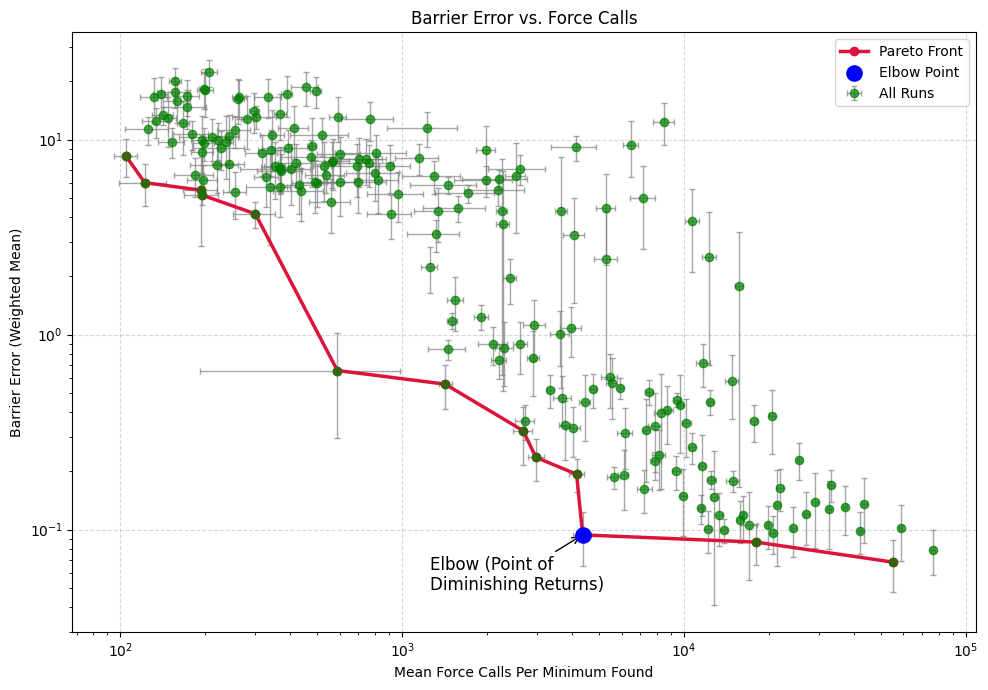

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Extract x and y values
x = np.array(grouped_for_pareto['mean_force_calls_per_min_mean'])
y = np.array(grouped_for_pareto['barrier_error_mean'])
xerr = np.array(grouped_for_pareto['mean_force_calls_per_min_stderr'])
yerr = np.array(grouped_for_pareto['barrier_error_stderr'])

def is_pareto_efficient(costs):
    """Return a boolean array indicating Pareto-efficient points."""
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            # Remove points that are dominated
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
            is_efficient[i] = True  # Keep self
    return is_efficient

def find_elbow_point(x, y):
    """
    Find the elbow point on a 2D curve (x, y).
    x, y should be sorted along x-axis.
    Returns index of elbow point.
    """
    start = np.array([x[0], y[0]])
    end = np.array([x[-1], y[-1]])
    line_vec = end - start
    line_vec_norm = line_vec / np.linalg.norm(line_vec)

    distances = []
    for xi, yi in zip(x, y):
        point_vec = np.array([xi, yi]) - start
        proj_len = np.dot(point_vec, line_vec_norm)
        proj_point = start + proj_len * line_vec_norm
        dist = np.linalg.norm(np.array([xi, yi]) - proj_point)
        distances.append(dist)

    distances = np.array(distances)
    elbow_idx = np.argmax(distances)
    return elbow_idx

def find_elbow_point_loglog(x, y):
    """
    Find elbow on log-log transformed points.
    x, y must be positive.
    Returns index of elbow point.
    """
    log_x = np.log10(x)
    log_y = np.log10(y)
    start = np.array([log_x[0], log_y[0]])
    end = np.array([log_x[-1], log_y[-1]])
    line_vec = end - start
    line_vec_norm = line_vec / np.linalg.norm(line_vec)

    distances = []
    for lx, ly in zip(log_x, log_y):
        point_vec = np.array([lx, ly]) - start
        proj_len = np.dot(point_vec, line_vec_norm)
        proj_point = start + proj_len * line_vec_norm
        dist = np.linalg.norm(np.array([lx, ly]) - proj_point)
        distances.append(dist)

    distances = np.array(distances)
    elbow_idx = np.argmax(distances)
    return elbow_idx

# Build costs array for Pareto analysis (minimize both x and y)
costs = np.vstack((x, y)).T
pareto_mask = is_pareto_efficient(costs)
pareto_x = x[pareto_mask]
pareto_y = y[pareto_mask]

# Sort Pareto front points by x for plotting
sort_idx = np.argsort(pareto_x)
pareto_x = pareto_x[sort_idx]
pareto_y = pareto_y[sort_idx]

# Find elbow point on Pareto front
# elbow_idx = find_elbow_point(pareto_x, pareto_y)
elbow_idx = find_elbow_point_loglog(pareto_x, pareto_y)
print("Elbow Point:")
print(grouped_for_pareto.iloc[elbow_idx])

# Log-log linear regression on Pareto front (optional)
log_x = np.log10(pareto_x)
log_y = np.log10(pareto_y)
m, b = np.polyfit(log_x, log_y, 1)
fit_log_x = np.linspace(log_x.min(), log_x.max(), 100)
fit_log_y = m * fit_log_x + b
fit_x = 10 ** fit_log_x
fit_y = 10 ** fit_log_y

# --- Plotting ---
plt.figure(figsize=(10, 7))

# Plot all points with error bars (comment out error bars easily)
plt.errorbar(
    x, y,
    xerr=xerr, yerr=yerr,
    fmt='o', color='green', alpha=0.7, label='All Runs',
    ecolor='gray', elinewidth=1, capsize=2
)
# To plot without error bars, comment out the above plt.errorbar() line and uncomment the below:
# plt.scatter(x, y, color='green', alpha=0.7, label='All Runs')

# Highlight Pareto front
plt.plot(pareto_x, pareto_y, 'o-', color='crimson', linewidth=2.5, markersize=6, label='Pareto Front')

# Highlight elbow point
plt.scatter(pareto_x[elbow_idx], pareto_y[elbow_idx], color='blue', s=120, zorder=5, label='Elbow Point')
plt.annotate(
    "Elbow (Point of \nDiminishing Returns)",
    xy=(pareto_x[elbow_idx], pareto_y[elbow_idx]),
    xytext=(-110, -40), textcoords='offset points',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=12, color='black'
)

# Optional: plot regression line on Pareto front
# plt.plot(fit_x, fit_y, '--', color='black', linewidth=2, label=f'Fit: slope = {m:.3f}')

# Labels and formatting
plt.xlabel("Mean Force Calls Per Minimum Found")
plt.ylabel("Barrier Error (Weighted Mean)")
plt.title("Barrier Error vs. Force Calls")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="major", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


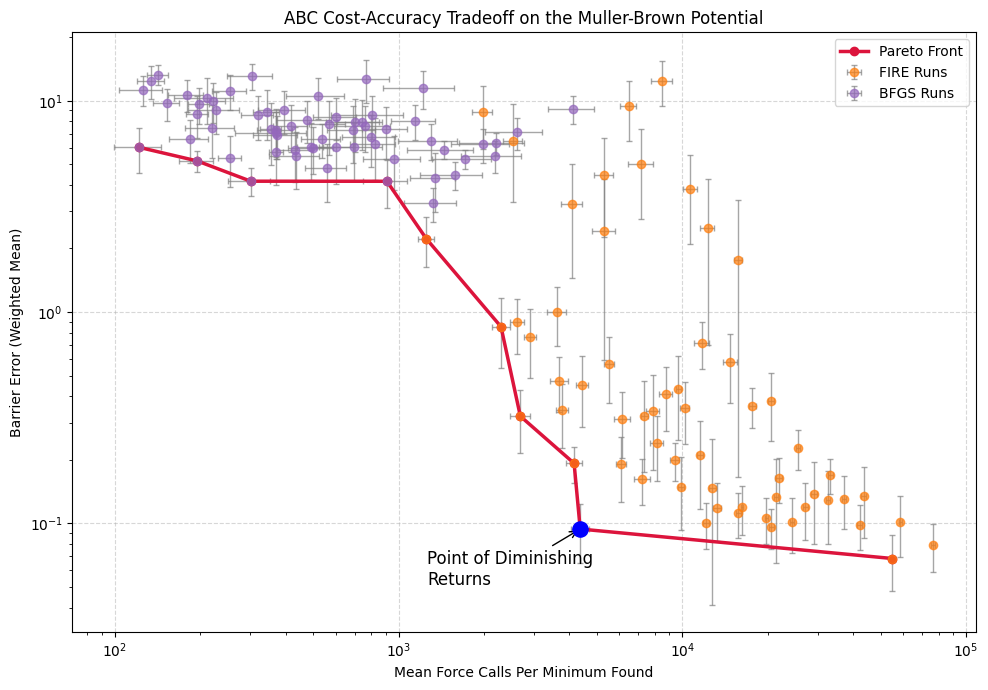

Elbow Point:
bias_height                            4.556086
bias_covariance                        0.008845
perturbation_size                         0.005
optimizer                                  FIRE
bias_count_mean                           114.2
bias_count_stderr                      8.067493
num_minima_mean                             3.0
num_minima_stderr                           0.0
num_saddles_mean                            2.0
num_saddles_stderr                          0.0
force_calls_at_final_min_mean           13103.9
force_calls_at_final_min_stderr      970.821799
mean_force_calls_per_min_mean       4367.966667
mean_force_calls_per_min_stderr      323.607266
energy_calls_at_final_min_mean          13103.9
energy_calls_at_final_min_stderr     970.821799
barrier_error_0_mean                   0.112949
barrier_error_0_stderr                 0.057463
barrier_error_1_mean                   0.075192
barrier_error_1_stderr                 0.009579
bias_std_dev_scale         

In [30]:
import matplotlib.pyplot as plt
import numpy as np

filtered_and_grouped_for_pareto = grouped_for_pareto[grouped_for_pareto['n_1']==10]

# Extract x and y values
x = np.array(filtered_and_grouped_for_pareto['mean_force_calls_per_min_mean'])
y = np.array(filtered_and_grouped_for_pareto['barrier_error_mean'])
xerr = np.array(filtered_and_grouped_for_pareto['mean_force_calls_per_min_stderr'])
yerr = np.array(filtered_and_grouped_for_pareto['barrier_error_stderr'])

def is_pareto_efficient(costs):
    """Return a boolean array indicating Pareto-efficient points."""
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            # Remove points that are dominated
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
            is_efficient[i] = True  # Keep self
    return is_efficient

def find_elbow_point(x, y):
    """
    Find the elbow point on a 2D curve (x, y).
    x, y should be sorted along x-axis.
    Returns index of elbow point.
    """
    start = np.array([x[0], y[0]])
    end = np.array([x[-1], y[-1]])
    line_vec = end - start
    line_vec_norm = line_vec / np.linalg.norm(line_vec)

    distances = []
    for xi, yi in zip(x, y):
        point_vec = np.array([xi, yi]) - start
        proj_len = np.dot(point_vec, line_vec_norm)
        proj_point = start + proj_len * line_vec_norm
        dist = np.linalg.norm(np.array([xi, yi]) - proj_point)
        distances.append(dist)

    distances = np.array(distances)
    elbow_idx = np.argmax(distances)
    return elbow_idx

def find_elbow_point_loglog(x, y):
    """
    Find elbow on log-log transformed points.
    x, y must be positive.
    Returns index of elbow point.
    """
    log_x = np.log10(x)
    log_y = np.log10(y)
    start = np.array([log_x[0], log_y[0]])
    end = np.array([log_x[-1], log_y[-1]])
    line_vec = end - start
    line_vec_norm = line_vec / np.linalg.norm(line_vec)

    distances = []
    for lx, ly in zip(log_x, log_y):
        point_vec = np.array([lx, ly]) - start
        proj_len = np.dot(point_vec, line_vec_norm)
        proj_point = start + proj_len * line_vec_norm
        dist = np.linalg.norm(np.array([lx, ly]) - proj_point)
        distances.append(dist)

    distances = np.array(distances)
    elbow_idx = np.argmax(distances)
    return elbow_idx

# Build costs array for Pareto analysis (minimize both x and y)
costs = np.vstack((x, y)).T
pareto_mask = is_pareto_efficient(costs)
pareto_x = x[pareto_mask]
pareto_y = y[pareto_mask]

# Sort Pareto front points by x for plotting
sort_idx = np.argsort(pareto_x)
pareto_x = pareto_x[sort_idx]
pareto_y = pareto_y[sort_idx]

# Find elbow point on Pareto front
# elbow_idx = find_elbow_point(pareto_x, pareto_y)
elbow_idx = find_elbow_point_loglog(pareto_x, pareto_y)


# Log-log linear regression on Pareto front (optional)
log_x = np.log10(pareto_x)
log_y = np.log10(pareto_y)
m, b = np.polyfit(log_x, log_y, 1)
fit_log_x = np.linspace(log_x.min(), log_x.max(), 100)
fit_log_y = m * fit_log_x + b
fit_x = 10 ** fit_log_x
fit_y = 10 ** fit_log_y

# --- Plotting ---
plt.figure(figsize=(10, 7))

# Define a color mapping for optimizer types
optimizer_colors = {
    'FIRE': 'tab:orange',
    'Scipy': 'tab:purple'
}

# Plot all points grouped by optimizer
for optimizer in filtered_and_grouped_for_pareto['optimizer'].unique():
    mask = filtered_and_grouped_for_pareto['optimizer'] == optimizer
    plt.errorbar(
        x[mask], y[mask],
        xerr=xerr[mask], yerr=yerr[mask],
        fmt='o',
        color=optimizer_colors.get(optimizer, 'gray'),
        alpha=0.7,
        label=f'{optimizer if optimizer=="FIRE" else "BFGS"} Runs',
        ecolor='gray', elinewidth=1, capsize=2
    )

# Highlight Pareto front
plt.plot(pareto_x, pareto_y, 'o-', color='crimson', linewidth=2.5, markersize=6, label='Pareto Front')

# Highlight elbow point
plt.scatter(pareto_x[elbow_idx], pareto_y[elbow_idx], color='blue', s=120, zorder=5) #, #label='Elbow Point')
plt.annotate(
    "Point of Diminishing \nReturns",
    xy=(pareto_x[elbow_idx], pareto_y[elbow_idx]),
    xytext=(-110, -40), textcoords='offset points',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=12, color='black'
)

# Optional: plot regression line on Pareto front
# plt.plot(fit_x, fit_y, '--', color='black', linewidth=2, label=f'Fit: slope = {m:.3f}')

# Labels and formatting
plt.xlabel("Mean Force Calls Per Minimum Found")
plt.ylabel("Barrier Error (Weighted Mean)")
plt.title("ABC Cost-Accuracy Tradeoff on the Muller-Brown Potential")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="major", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


# Extract the DataFrame rows on the Pareto front
pareto_runs = filtered_and_grouped_for_pareto[pareto_mask].copy()
pareto_runs = pareto_runs.iloc[sort_idx].reset_index(drop=True)
print("Elbow Point:")
print(pareto_runs.iloc[elbow_idx])


Note: we use this one, which filters out all combinations that did not successfully identify 3 minima and 2 saddles within 5000 bias placements every single time

In [32]:
pareto_runs.iloc[-2] #.to_json("pareto_runs.json", orient="records", indent=2)

bias_height                            4.556086
bias_covariance                        0.008845
perturbation_size                         0.005
optimizer                                  FIRE
bias_count_mean                           114.2
bias_count_stderr                      8.067493
num_minima_mean                             3.0
num_minima_stderr                           0.0
num_saddles_mean                            2.0
num_saddles_stderr                          0.0
force_calls_at_final_min_mean           13103.9
force_calls_at_final_min_stderr      970.821799
mean_force_calls_per_min_mean       4367.966667
mean_force_calls_per_min_stderr      323.607266
energy_calls_at_final_min_mean          13103.9
energy_calls_at_final_min_stderr     970.821799
barrier_error_0_mean                   0.112949
barrier_error_0_stderr                 0.057463
barrier_error_1_mean                   0.075192
barrier_error_1_stderr                 0.009579
bias_std_dev_scale                     0

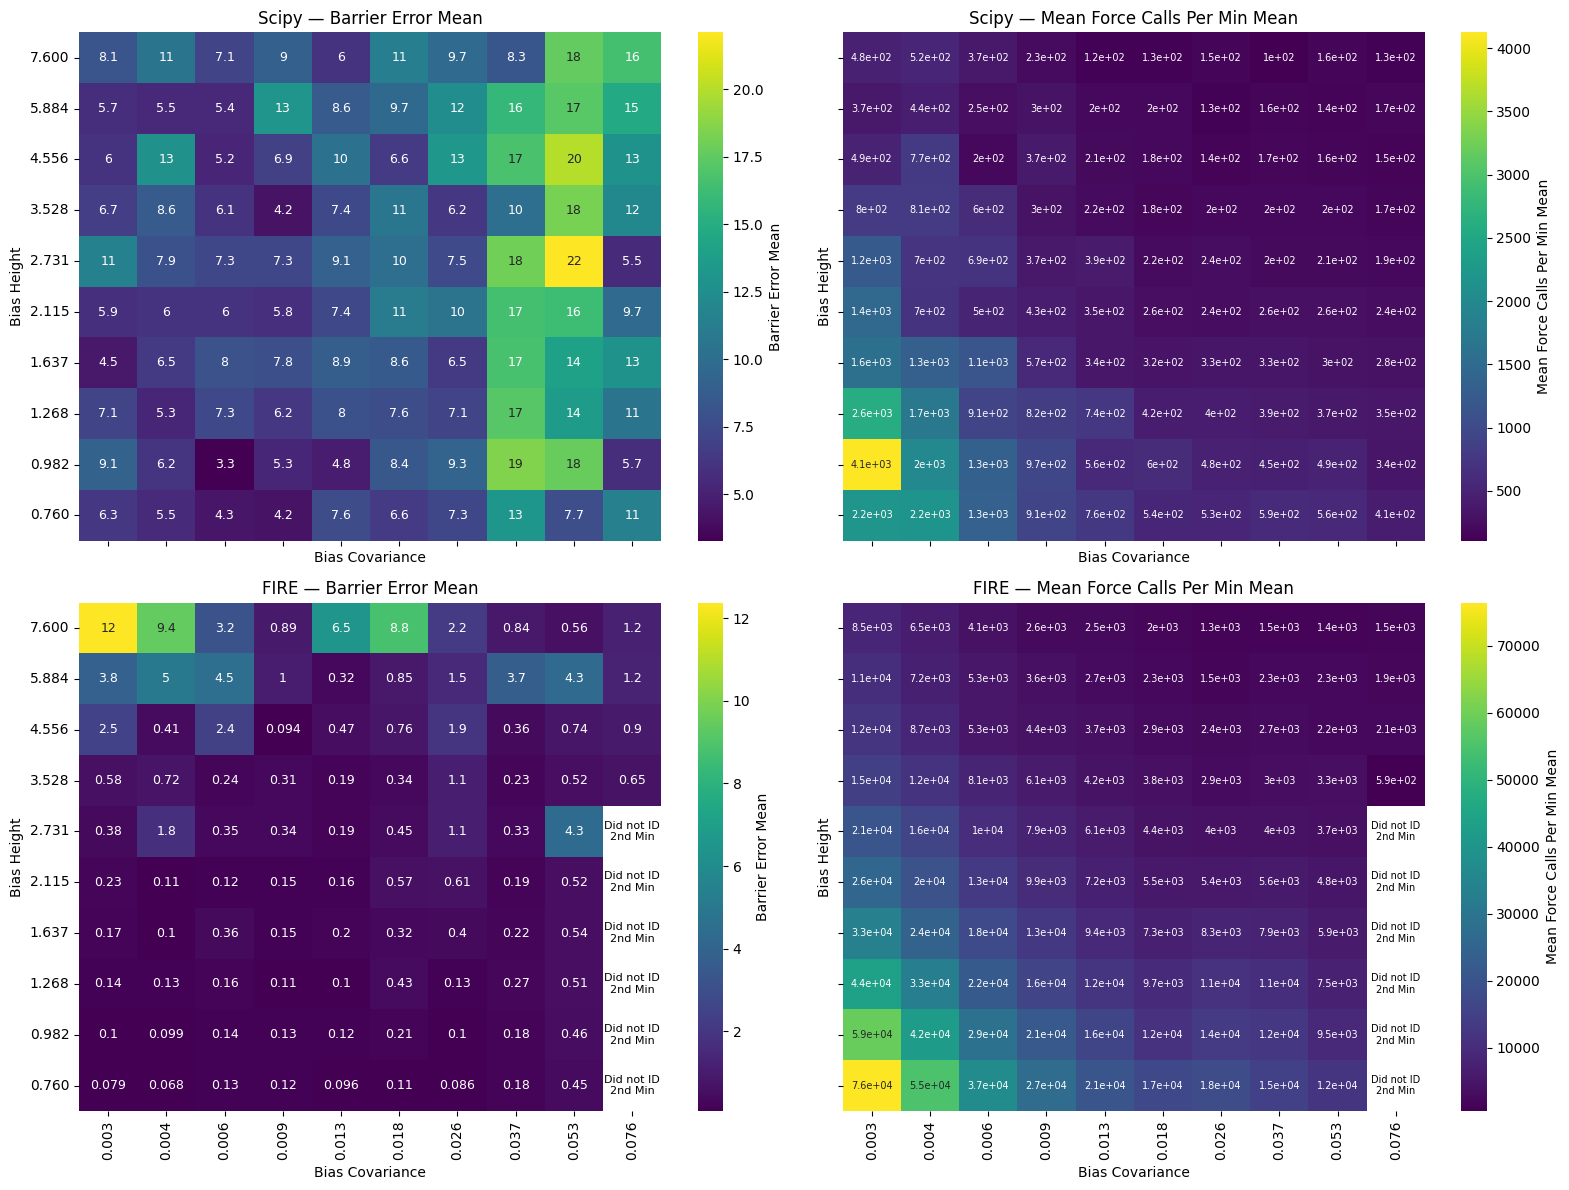

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assumes: grouped_for_pareto is already filtered to remove NaNs

# Define heatmap parameters
x_param = 'bias_covariance'
y_param = 'bias_height'
metrics = ['barrier_error_mean', 'mean_force_calls_per_min_mean']
optimizers = ['Scipy', 'FIRE']

# Create figure
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(16, 12),
    sharex=True, sharey=True
)

for row_idx, optimizer in enumerate(optimizers):
    for col_idx, metric in enumerate(metrics):
        ax = axes[row_idx, col_idx]

        # Filter for the optimizer
        df_opt = grouped_for_pareto[grouped_for_pareto['optimizer'] == optimizer]

        # Pivot table for heatmap
        heatmap_data = df_opt.pivot_table(
            index=y_param, columns=x_param, values=metric
        )

        # Sort axes numerically ascending
        heatmap_data = heatmap_data.sort_index(ascending=True).sort_index(axis=1, ascending=True)

        # Build annotation matrix with fallback message for NaNs
        annot_matrix = heatmap_data.copy().astype(object)

        for i in range(annot_matrix.shape[0]):
            for j in range(annot_matrix.shape[1]):
                val = annot_matrix.iloc[i, j]
                if pd.isna(val):
                    annot_matrix.iloc[i, j] = "Did not ID 2nd Min"
                else:
                    annot_matrix.iloc[i, j] = f"{val:.2g}"

        # Choose smaller font for crowded force plots
        annot_kws = {'size': 7} if 'force_calls' in metric else {'size': 9}
        annot_fontsize = 7 if 'force_calls' in metric else 8

        # Plot heatmap with custom annotation strings
        sns.heatmap(
            heatmap_data,
            ax=ax,
            cmap='viridis',
            cbar_kws={'label': metric.replace('_', ' ').title()},
            annot=annot_matrix,
            fmt='',  # Use string annotations as-is
            annot_kws=annot_kws,
            xticklabels=True, yticklabels=True
        )

        # Overlay custom annotations manually (including NaNs)
        for i in range(heatmap_data.shape[0]):
            for j in range(heatmap_data.shape[1]):
                val = heatmap_data.iloc[i, j]
                text = "Did not ID\n2nd Min" if pd.isna(val) else None
                ax.text(
                    j + 0.5, i + 0.5, text,
                    ha='center', va='center',
                    fontsize=annot_fontsize, color='black'
                )

        # Invert y-axis back to normal (bottom = low, top = high)
        ax.invert_yaxis()

        # Format tick labels to 3 decimal places
        ax.set_xticks(np.arange(len(heatmap_data.columns)) + 0.5)
        ax.set_yticks(np.arange(len(heatmap_data.index)) + 0.5)
        ax.set_xticklabels([f"{v:.3f}" for v in heatmap_data.columns])
        ax.set_yticklabels([f"{v:.3f}" for v in heatmap_data.index])

        # Labels and title
        ax.set_title(f'{optimizer} — {metric.replace("_", " ").title()}')
        ax.set_xlabel('Bias Covariance')
        ax.set_ylabel('Bias Height')

plt.tight_layout()
plt.show()

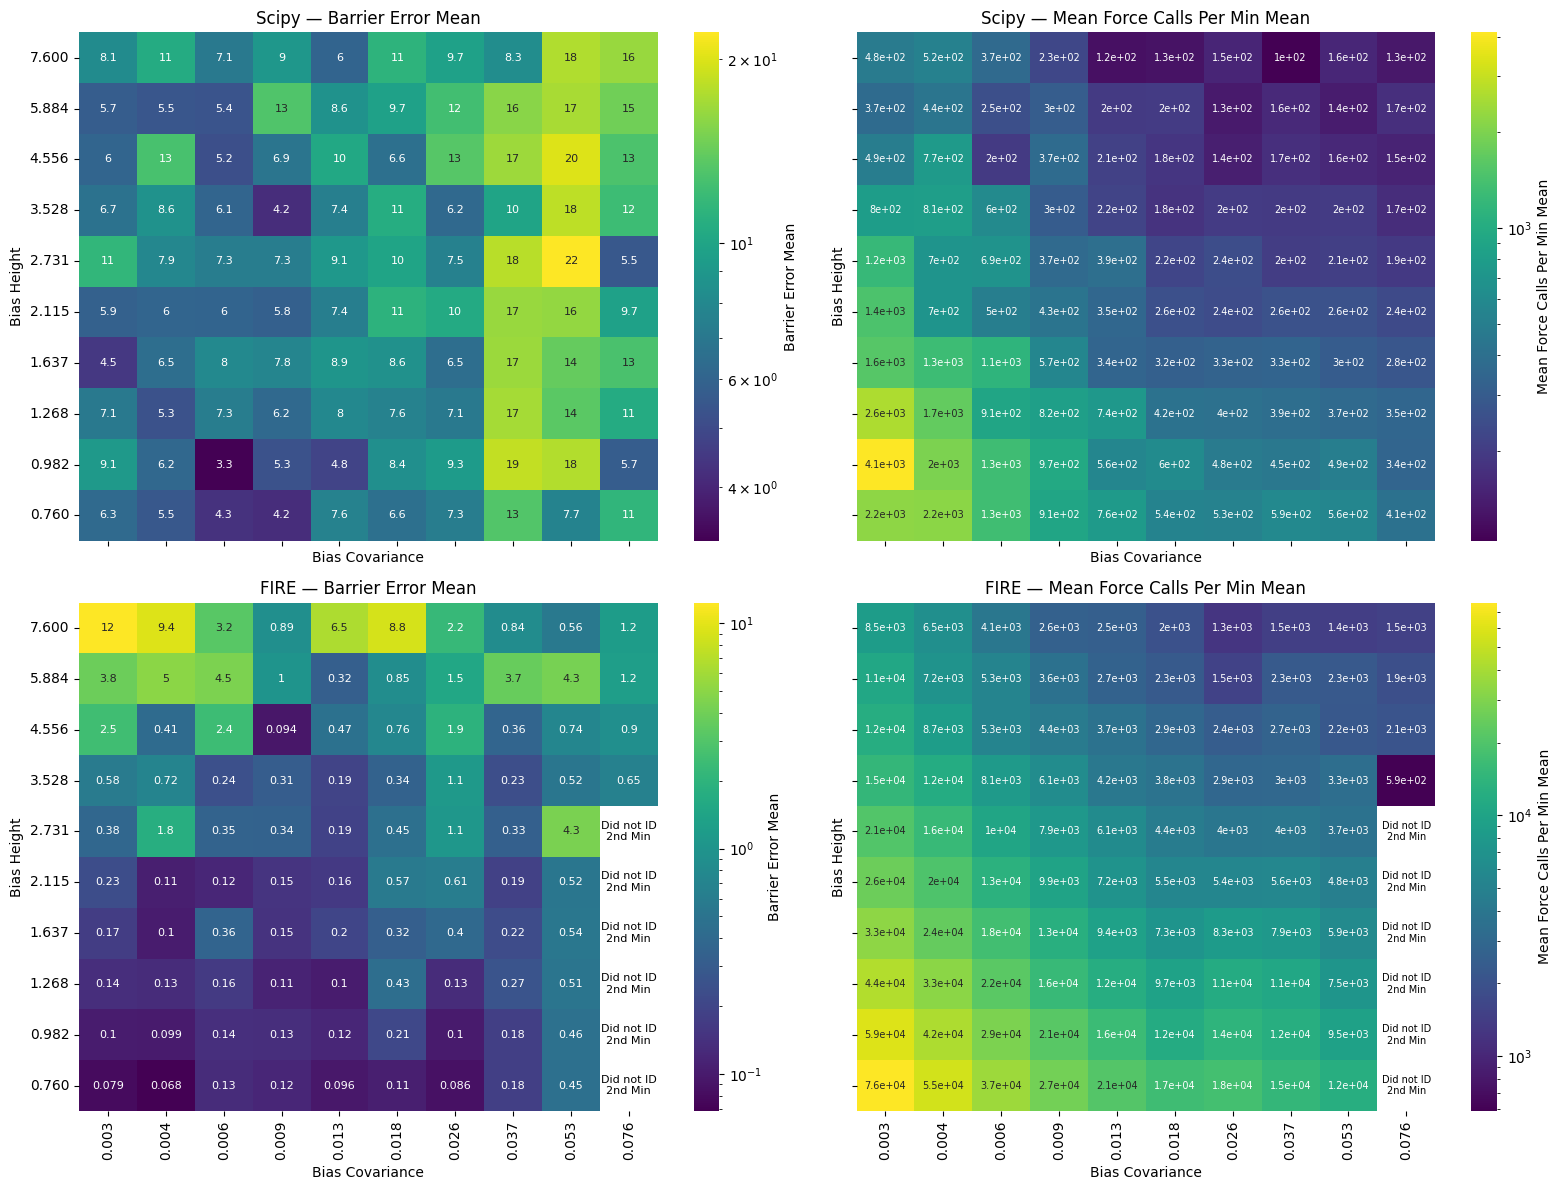

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm

# Assumes: grouped_for_pareto is already filtered to remove NaNs

# Define heatmap parameters
x_param = 'bias_covariance'
y_param = 'bias_height'
metrics = ['barrier_error_mean', 'mean_force_calls_per_min_mean']
optimizers = ['Scipy', 'FIRE']

# Create figure
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(16, 12),
    sharex=True, sharey=True
)

for row_idx, optimizer in enumerate(optimizers):
    for col_idx, metric in enumerate(metrics):
        ax = axes[row_idx, col_idx]

        # Filter for the optimizer
        df_opt = grouped_for_pareto[grouped_for_pareto['optimizer'] == optimizer]

        # Pivot table for heatmap
        heatmap_data = df_opt.pivot_table(
            index=y_param, columns=x_param, values=metric
        )

        # Sort axes numerically ascending
        heatmap_data = heatmap_data.sort_index(ascending=True).sort_index(axis=1, ascending=True)

        # Build annotation matrix with fallback message for NaNs
        annot_matrix = heatmap_data.copy().astype(object)

        for i in range(annot_matrix.shape[0]):
            for j in range(annot_matrix.shape[1]):
                val = annot_matrix.iloc[i, j]
                if pd.isna(val):
                    annot_matrix.iloc[i, j] = "Did not ID 2nd Min"
                else:
                    annot_matrix.iloc[i, j] = f"{val:.2g}"

        # Choose smaller font for crowded force plots
        annot_fontsize = 7 if 'force_calls' in metric else 8

        # Determine vmin, vmax for LogNorm (ignore NaNs)
        values = heatmap_data.values.flatten()
        values = values[~np.isnan(values)]
        vmin = values[values > 0].min() if np.any(values > 0) else 1e-3  # fallback min
        vmax = values.max()

        # Plot heatmap with logarithmic color scale
        sns.heatmap(
            heatmap_data,
            ax=ax,
            cmap='viridis',
            norm=LogNorm(vmin=vmin, vmax=vmax),
            cbar_kws={'label': metric.replace('_', ' ').title()},
            annot=annot_matrix,
            fmt='',  # Use string annotations as-is
            annot_kws={'size': annot_fontsize},
            xticklabels=True, yticklabels=True
        )

        # Overlay NaN annotations explicitly (to avoid overlap)
        for i in range(heatmap_data.shape[0]):
            for j in range(heatmap_data.shape[1]):
                val = heatmap_data.iloc[i, j]
                if pd.isna(val):
                    ax.text(
                        j + 0.5, i + 0.5, "Did not ID\n2nd Min",
                        ha='center', va='center',
                        fontsize=annot_fontsize, color='black'
                    )

        # Invert y-axis back to normal (bottom = low, top = high)
        ax.invert_yaxis()

        # Format tick labels to 3 decimal places
        ax.set_xticks(np.arange(len(heatmap_data.columns)) + 0.5)
        ax.set_yticks(np.arange(len(heatmap_data.index)) + 0.5)
        ax.set_xticklabels([f"{v:.3f}" for v in heatmap_data.columns])
        ax.set_yticklabels([f"{v:.3f}" for v in heatmap_data.index])

        # Labels and title
        ax.set_title(f'{optimizer} — {metric.replace("_", " ").title()}')
        ax.set_xlabel('Bias Covariance')
        ax.set_ylabel('Bias Height')

plt.tight_layout()
plt.show()
